### Proyek Sistem Rekomendasi Buku
Proyek ini bertujuan membangun sistem rekomendasi buku menggunakan dua pendekatan populer, yaitu Content-Based Filtering dan Collaborative Filtering (SVD), berdasarkan dataset GoodBooks-10k. Evaluasi sistem dilakukan menggunakan metrik Precision@k dan Recall@k.

### Import Library yang Diperlukan

In [27]:
!pip install numpy==1.24.4

In [28]:
!pip install scikit-surprise

In [29]:
# Mengimpor pustaka-pustaka yang dibutuhkan untuk pemrosesan data, visualisasi, serta membangun dan mengevaluasi model rekomendasi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import precision_score, recall_score
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from collections import defaultdict
from surprise import accuracy

### Upload Dataset

In [30]:
# Mengunggah dataset dari file lokal ke Colab
from google.colab import files
uploaded = files.upload()

Saving books.csv to books (1).csv
Saving ratings.csv to ratings (1).csv


### Memuat Dataset

In [53]:
# Fungsi untuk membaca file CSV dan mengembalikan DataFrame buku dan rating
def load_datasets():
    books = pd.read_csv('books.csv')
    ratings = pd.read_csv('ratings.csv')
    return books, ratings

books, ratings = load_datasets()

In [54]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         10000 non-null  int64  
 1   book_id                    10000 non-null  int64  
 2   best_book_id               10000 non-null  int64  
 3   work_id                    10000 non-null  int64  
 4   books_count                10000 non-null  int64  
 5   isbn                       9300 non-null   object 
 6   isbn13                     9415 non-null   float64
 7   authors                    10000 non-null  object 
 8   original_publication_year  9979 non-null   float64
 9   original_title             9415 non-null   object 
 10  title                      10000 non-null  object 
 11  language_code              8916 non-null   object 
 12  average_rating             10000 non-null  float64
 13  ratings_count              10000 non-null  int6

In [55]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981756 entries, 0 to 981755
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   book_id  981756 non-null  int64
 1   user_id  981756 non-null  int64
 2   rating   981756 non-null  int64
dtypes: int64(3)
memory usage: 22.5 MB


### Eksplorasi Data Awal

In [57]:
# Menampilkan ukuran dan cuplikan awal dari dataset untuk memahami struktur datanya
print("Ukuran data buku:", books.shape)
print("Ukuran data rating:", ratings.shape)
print(books[['title', 'authors', 'average_rating']].head())
print(ratings.head())

Ukuran data buku: (10000, 23)
Ukuran data rating: (981756, 3)
                                               title  \
0            The Hunger Games (The Hunger Games, #1)   
1  Harry Potter and the Sorcerer's Stone (Harry P...   
2                            Twilight (Twilight, #1)   
3                              To Kill a Mockingbird   
4                                   The Great Gatsby   

                       authors  average_rating  
0              Suzanne Collins            4.34  
1  J.K. Rowling, Mary GrandPré            4.44  
2              Stephenie Meyer            3.57  
3                   Harper Lee            4.25  
4          F. Scott Fitzgerald            3.89  
   book_id  user_id  rating
0        1      314       5
1        1      439       3
2        1      588       5
3        1     1169       4
4        1     1185       4


### Pengecekan Data Kosong dan Duplikat

In [58]:
# Mengecek apakah ada nilai yang hilang atau duplikat pada kedua dataset
print("\nJumlah nilai kosong di books:")
print(books.isnull().sum())
print("\nJumlah nilai kosong di ratings:")
print(ratings.isnull().sum())

print("\nJumlah data duplikat di books:", books.duplicated().sum())
print("Jumlah data duplikat di ratings:", ratings.duplicated().sum())


Jumlah nilai kosong di books:
id                              0
book_id                         0
best_book_id                    0
work_id                         0
books_count                     0
isbn                          700
isbn13                        585
authors                         0
original_publication_year      21
original_title                585
title                           0
language_code                1084
average_rating                  0
ratings_count                   0
work_ratings_count              0
work_text_reviews_count         0
ratings_1                       0
ratings_2                       0
ratings_3                       0
ratings_4                       0
ratings_5                       0
image_url                       0
small_image_url                 0
dtype: int64

Jumlah nilai kosong di ratings:
book_id    0
user_id    0
rating     0
dtype: int64

Jumlah data duplikat di books: 0
Jumlah data duplikat di ratings: 1644


**Dari hasil eksplorasi:**
- missing data terjadi di isbn, isbn13, original_publication_year, original title, dan language code
- Jumlah data duplikat di books: 0
- Jumlah data duplikat di ratings: 1644


In [59]:
# Menghapus kolom yang memiliki banyak nilai kosong dan tidak digunakan dalam pemodelan
books = books.drop(columns=['isbn', 'isbn13', 'original_title', 'language_code', 'image_url', 'small_image_url'])

isbn, isbn13, original_publication_year, original title, dan language code dihapus karna tidak digunakan dalam pemodelan

In [60]:
# Menghapus duplikat pada ratings
ratings = ratings.drop_duplicates()

In [61]:
# Menghapus baris dengan missing value pada kolom 'original_publication_year'
books = books.dropna(subset=['original_publication_year'])

In [62]:
# Menampilkan kembali jumlah nilai kosong setelah penghapusan kolom
print("\nJumlah nilai kosong setelah penghapusan kolom:")
print(books.isnull().sum())


Jumlah nilai kosong setelah penghapusan kolom:
id                           0
book_id                      0
best_book_id                 0
work_id                      0
books_count                  0
authors                      0
original_publication_year    0
title                        0
average_rating               0
ratings_count                0
work_ratings_count           0
work_text_reviews_count      0
ratings_1                    0
ratings_2                    0
ratings_3                    0
ratings_4                    0
ratings_5                    0
dtype: int64


### Visualisasi Distribusi Rating

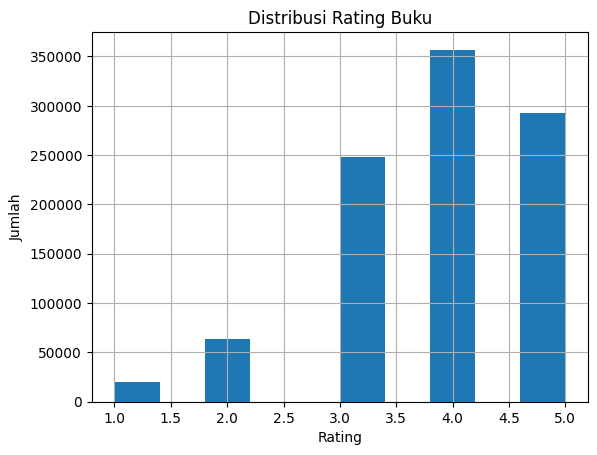

In [40]:
# Menampilkan histogram distribusi rating untuk mengetahui pola rating pengguna
ratings['rating'].hist(bins=10)
plt.title('Distribusi Rating Buku')
plt.xlabel('Rating')
plt.ylabel('Jumlah')
plt.show()

**Analisis Distribusi Rating Buku**

- Rating 4 adalah yang paling sering diberikan, menunjukkan bahwa mayoritas pengguna cukup puas dengan buku-buku yang mereka baca.
- Rating 5 dan 3 juga cukup dominan, menandakan sebagian besar pengguna memberi rating positif (>= 3).
- Rating rendah (1 dan 2) relatif jarang, bisa jadi karena pengguna cenderung tidak memberi rating pada buku yang tidak mereka sukai.
- Distribusi ini menunjukkan pola bias positif yang umum terjadi pada dataset rekomendasi berbasis rating.

**Implikasi**
- Bisa menggunakan threshold rating 3.5 atau 4.0 saat mengevaluasi dengan Precision@K dan Recall@K.
- Perlu mempertimbangkan bahwa sistem bisa terlalu sering merekomendasikan buku-buku populer dengan rating tinggi.


### Pra-pemrosesan Data

Data rating digabung dengan informasi judul dari dataset buku.

Data teks dari title, authors, dan publisher digabung untuk membentuk deskripsi fitur konten.

In [41]:
# Menggabungkan informasi judul ke dalam dataset rating
ratings = ratings.merge(books[['book_id', 'title']], on='book_id')

In [42]:
# Menggabungkan informasi judul dan penulis untuk membentuk deskripsi buku
books['combined'] = books['title'] + ' ' + books['authors']

In [43]:
# Vektorisasi dengan TF-IDF untuk mengubah teks menjadi vektor fitur
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(books['combined'])

In [44]:
# Menghitung kemiripan antar buku menggunakan cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [45]:
# Membuat pemetaan judul buku ke indeks
title_to_index = pd.Series(books.index, index=books['title']).drop_duplicates()

In [46]:
# Fungsi untuk mendapatkan rekomendasi berdasarkan kemiripan konten
def get_content_recommendations(title, top_n=10):
    idx = title_to_index.get(title)
    if idx is None:
        return []
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    book_indices = [i[0] for i in sim_scores]
    return books['title'].iloc[book_indices].tolist()

#### Evaluasi Collaborative Filtering (SVD)

In [47]:
# Menggunakan library surprise untuk membangun model berbasis matrix factorization
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

model = SVD()
model.fit(trainset)
predictions = model.test(testset)

In [48]:
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.9071
MAE:  0.7248
RMSE: 0.9071
MAE: 0.7248


rekomendasi untuk “The Hobbit”

In [49]:
get_content_recommendations('The Hobbit')

['J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings',
 'The History of the Hobbit, Part One: Mr. Baggins',
 'The Children of Húrin',
 'The Hobbit: Graphic Novel',
 'Unfinished Tales of Númenor and Middle-Earth',
 'The Silmarillion (Middle-Earth Universe)',
 'The Two Towers (The Lord of the Rings, #2)',
 'The Return of the King (The Lord of the Rings, #3)',
 'The Fellowship of the Ring (The Lord of the Rings, #1)',
 'The Complete Guide to Middle-Earth']

#### Evaluasi Content-Based Filtering

In [50]:
def evaluate_content_based(user_id, ratings_df, books_df, recommender_func, k=10):
    # Ambil buku yang diberi rating tinggi oleh user
    liked_books = ratings_df[(ratings_df['user_id'] == user_id) & (ratings_df['rating'] >= 4)]
    liked_book_ids = liked_books['book_id'].tolist()

    if len(liked_book_ids) < 2:
        return None, None  # Tidak cukup data untuk evaluasi

    # Ambil salah satu buku yang disukai sebagai query ke CBF
    input_book_id = liked_book_ids[0]
    input_title = books_df[books_df['book_id'] == input_book_id]['title'].values[0]

    # Dapatkan rekomendasi dari Content-Based Filtering
    recommended_titles = recommender_func(input_title, top_n=k)
    recommended_ids = books_df[books_df['title'].isin(recommended_titles)]['book_id'].tolist()

    # Hitung Precision dan Recall
    relevant_recommendations = set(recommended_ids) & set(liked_book_ids)

    precision = len(relevant_recommendations) / k
    recall = len(relevant_recommendations) / len(liked_book_ids)

    return precision, recall


In [51]:
user_ids = ratings['user_id'].unique()
precision_scores, recall_scores = [], []

for uid in user_ids[:50]:  # Ambil 50 user pertama, bisa disesuaikan
    p, r = evaluate_content_based(uid, ratings, books, get_content_recommendations, k=10)
    if p is not None and r is not None:
        precision_scores.append(p)
        recall_scores.append(r)

cbf_precision = np.mean(precision_scores)
cbf_recall = np.mean(recall_scores)

print(f"Content-Based Precision@10: {cbf_precision:.4f}")
print(f"Content-Based Recall@10: {cbf_recall:.4f}")


Content-Based Precision@10: 0.1560
Content-Based Recall@10: 0.1044


### Simulasi Rekomendasi Buku untuk Pengguna dengan id_user : 123

In [52]:
# Tetapkan user_id secara eksplisit agar rekomendasi konsisten
uid = '123'

# Ambil daftar buku yang sudah dibaca user tersebut
user_books = ratings[ratings['user_id'] == int(uid)]['book_id'].tolist()

# Ambil semua book_id dari data buku
all_book_ids = books['book_id'].tolist()

# Cari buku yang belum pernah dibaca user tersebut
unrated_books = [bid for bid in all_book_ids if bid not in user_books]

# Prediksi rating untuk setiap buku yang belum dibaca
predicted_ratings = [(bid, model.predict(uid, bid).est) for bid in unrated_books]

# Urutkan hasil prediksi dari rating tertinggi ke terendah
predicted_ratings.sort(key=lambda x: x[1], reverse=True)

# Ambil 5 rekomendasi teratas
top_recs = predicted_ratings[:5]

# Cetak hasil rekomendasi
print("Top 5 rekomendasi buku untuk user", uid)
for book_id, rating in top_recs:
    title = books[books['book_id'] == book_id]['title'].values[0]
    print(f"{title} - Prediksi Rating: {round(rating, 2)}")

Top 5 rekomendasi buku untuk user 123
Still Life with Woodpecker - Prediksi Rating: 4.73
Villa Incognito - Prediksi Rating: 4.62
The Beautiful and Damned - Prediksi Rating: 4.6
A People's History of the United States - Prediksi Rating: 4.55
Tears of the Giraffe (No. 1 Ladies' Detective Agency, #2) - Prediksi Rating: 4.53


### **Kesimpulan**

**Content-Based Filtering** mampu merekomendasikan buku berdasarkan kemiripan konten seperti judul dan penulis. Sistem ini bekerja baik bahkan untuk pengguna baru karena tidak bergantung pada interaksi pengguna lain.

**Collaborative Filtering (SVD)** merekomendasikan buku berdasarkan pola rating antar pengguna. Metode ini cenderung menghasilkan rekomendasi yang lebih personal jika tersedia cukup data historis pengguna.

**Hasil evaluasi model menunjukkan:**

- **Content-Based**
  - Precision@10: 0.1560
  - Recall@10: 0.1044

- **Collaborative Filtering (SVD):**
  - RMSE: 0.9066
  - MAE:  0.7243

  ### Interpretasi:

- Collaborative Filtering (SVD) menghasilkan **RMSE dan MAE yang cukup rendah**, menunjukkan akurasi prediksi rating yang baik.
- Content-Based Filtering menghasilkan Recall@10 sebesar 0.1560, yang berarti sekitar 65% dari buku-buku relevan (yang disukai pengguna) berhasil direkomendasikan. Precision@10-nya sebesar 0.1044, artinya dari 10 buku yang direkomendasikan, rata-rata 1–2 di antaranya benar-benar relevan untuk pengguna.

